In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
from tools import *
# from h5_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import pandas as pd

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
!ls -l /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/

total 41853344
-rw-rw-r--+ 1 mabi3848 hpc-users  120392345 Jul 11  2023 apo_conc_gly_50_2_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users      23079 Jun 28  2023 background_0003.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1161373434 Jul 11  2023 ferritin_conc100_gly_50_1_0002.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  703980477 Jul 11  2023 ferritin_conc100_gly_50_1_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2330393309 Jul 11  2023 ferritin_conc100_gly_50_1_0009.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1144299172 Jul 11  2023 ferritin_conc100_gly_50_1_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2461504414 Jul 11  2023 ferritin_conc100_gly_50_1_0012.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2539875762 Jul  5  2023 ferritin_conc100_gly_50_1_0013.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1604681690 Jul  5  2023 ferritin_conc100_gly_50_1_0014.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  745507304 Jul 13  2023 ferritin_conc100_gly_50_2_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  527515584 Jul 13  2023 ferritin_conc100_gly_50_2_0011.h5
-rw-rw-

In [5]:
# 240
runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
datasetnumbers = [3,9,7] # 240 K

# lowest temps
# runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
# datasetnumbers = [6, 9, 8] # 210, 


In [6]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc100_gly_50_1_0009.h5 
File exists:  True 

measurement folder   ferritin_conc100_gly_50_1_0009
Temperature, K       240.0
transmission (%)     nan
Absorbers 80um       nan
Absorbers 100um      nan
Short comment        nan
comment              nan
Exposure time (s)    nan
number of frames     nan
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 
File exists:  True 

measurement folder   ferritin_conc120_gly_50_1_0007
Temperature, K       240.0
transm

# Plot g2s

In [7]:
# with h5py.File( h5dir + f'{runnames[-1]}_{datasetnumbers[-1]:04d}.h5', 'r') as f: 
#     f.visititems(visit_func)

In [8]:
filename = h5dir + f'{runnames[0]}_{datasetnumbers[0]:04d}.h5'
len_g2 = len(load_data(filename, 'xpcs/g2s/delay'))
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len_g2))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len_g2))
delays = np.empty(shape=(len(datasetnumbers),len_g2))

for i, (datasetnumber,runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    print(filename, os.path.isfile(filename))
    
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')


/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 True
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc100_gly_50_1_0009.h5 True
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 True


In [9]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')
etas = viscosity()
eta_50 = {} #etas['50w%']
for i in etas.index:
    # print(i, etas.iloc[i]['temp'], etas.iloc[i]['50w%'])
    key = etas.iloc[i]['temp']
    eta_50[key] = etas.iloc[i]['50w%']
# eta_50

### With kww=1

In [10]:
concs_l = ['c1', 'c2', 'c3']
concs = [31, 44, 64]


 c 31 mg/ml,  240 K

 c 44 mg/ml,  240 K

 c 64 mg/ml,  240 K


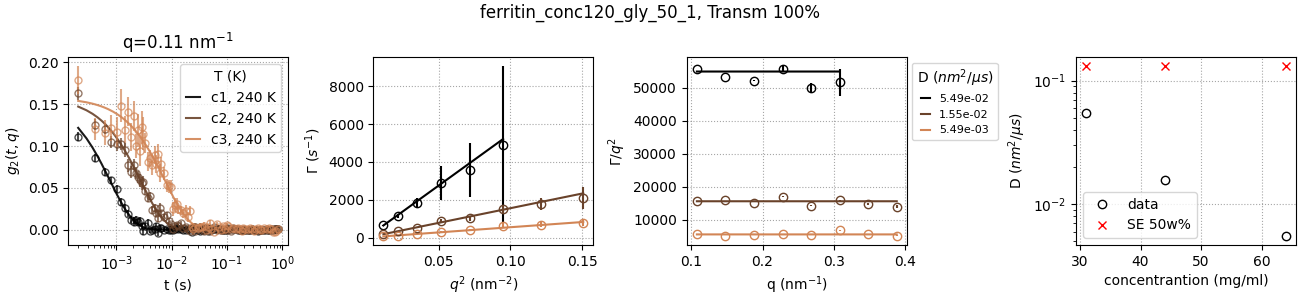

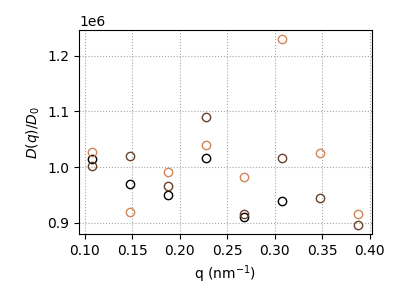

In [11]:
f, (a1,a3,a4,a2) = plt.subplots(1,4, figsize=(13,3), constrained_layout=True)
f2, a5 = plt.subplots(1,1, figsize=(4,3), tight_layout=True)

col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)+1))
qv_sel = 2
tol = 1e-3

qv_min, qv_max, qstep = 2, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    print('\n', f'c {concs[i]} mg/ml, ', f'{T[i][:-2]} K')
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            # a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{concs_l[i]}, {T[i][:-2]} K')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)

    cond = (taus>dtaus) & (dtaus!=0)
    # print(T[i][:-2], qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2))
    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    # print(T[i][:-2],  popt[0], perr[0])

    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a4.plot(np.sqrt(xc), curve/xc, c=col[i], label=f'{Ds[0,i]:.2e}')
    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    a4.errorbar(qs[cond], 1/taus[cond]/qs[cond]**2, dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a2.plot(concs[i], Ds[0,i], ls='', marker='o', mfc='none', c='k')
    a2.plot(concs[i], D_coeff(T=float(T[i]), eta=eta_50[float(T[i])])*1e12 , ls='', marker='x', mfc='none', c='r')

    a5.plot(qs[cond], 1/taus[cond]/qs[cond]**2/Ds[0,i], c=col[i], ls='', marker='o', mfc='none')

a1.legend(title=r'T (K)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_title(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$")
f.suptitle(f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
# a3.set_ylim(0,1e4)
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma/q^2$')
a2.set_xlabel('concentrantion (mg/ml)')
a2.set_ylabel('D (${{nm}}^{{2}}$/${{\mu s}}$)')
a2.set_yscale('log')
a4.legend(title='D (${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.8, bbox_to_anchor=[1,1])
a2.legend(['data', 'SE 50w%'], fontsize=10)
a5.set_xlabel(r'q (nm$^{-1}$)')
a5.set_ylabel(r'$D(q)/D_0$');

In [12]:
f = np.load("../03-source/xfel.npz")
xfel = {}
for key in f.files:
    xfel[key] = f[key]
    # print(key, np.shape(xfel[key]))

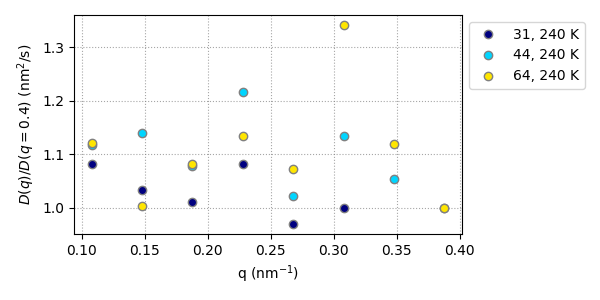

In [13]:
f, a1 = plt.subplots(1,1, figsize=(6,3), tight_layout=True)
col = plt.cm.jet(np.linspace(0,1,len(datasetnumbers)+1))
col2 = plt.cm.jet(np.linspace(0,1,3))

# -- id10
qv_sel, tol = 2, 1e-3
qv_min, qv_max, qstep = 2, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    # print('\n', concs[i])
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0)
    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    # a1.plot(qs[cond], 1/taus[cond]/qs[cond]**2, c=col[i], ls='', marker='o', mec='gray', label=f'id10 {concs[i]}, {T[i][:-2]} K')
    D = 1/taus[cond]/qs[cond]**2
    a1.plot(qs[cond], D/D[-1], c=col[i], ls='', marker='o', mec='gray', alpha=1, label=f'{concs[i]}, {T[i][:-2]} K')

# -- xfel

# for i in range(3):
#     # a1.plot(xfel['qvalues'], xfel['D'][i,:], c=col2[i], marker='o', mec='gray', ls='', label=f'xfel {i}')
#     a1.plot(xfel['qvalues'][:-5], xfel['D'][i,:-5] / xfel['D'][i,5], label=f'xfel {i}', c=col[::-1][i], ls='-', )#marker='s', ls='', alpha=1, mfc='none', ) # mec='gray',

a1.set_yscale('linear')
a1.set_xlabel(r'q (nm$^{-1}$)')
a1.set_ylabel(r'$D(q)/D(q=0.4)$ (nm$^{2}$/s)')
a1.legend(bbox_to_anchor=[1,1])

Check the order of concentrations for xfel data

# Scattering intensity

In [14]:
filename = h5dir + f'{runnames[0]}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber,runname) in enumerate(zip(datasetnumbers,runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iq = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    # arr = np.where(arr==0, np.nan, arr)
    Iqs[i,:] = np.where(Iq==0, np.nan, Iq)

    info = elog_selected_entries_dict(filename)
    t_exp.append(delays[i,0])
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

3 0.0002 s
9 0.0002 s
7 0.0002 s
(3, 1000) (1000,)


In [15]:
# bkg 0003 "vacuum"
f = np.load("../03-source/bkg_background_0003.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg = np.where(f['Iq']==0, np.nan, f['Iq'])
q_bkg = f['q']
t_exp_bkg = 1e-1

# water/glycerol
f = np.load("../03-source/bkg_water_gly_50_2_0002.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg_w = f['Iq'][2,:]
Iq_bkg_w = np.where(f['Iq'][2,:]==0, np.nan, f['Iq'][2,:])
q_bkg_w = f['q']
# q_bkg_w = q_bkg_w[f['Iq'][2,:] != 0]
t_exp_bkg_w = 1e-1

# apoferritin
# f = np.load("../03-source/Iqs_apo_conc_gly_50_2_0006.npz")
# f.files
# Iq_apo = np.average(f['Iqs'],axis=0)
# q_apo = f['q']
# t_exp_apo = 5e-3

# apoferritin short exp time
f = np.load("../03-source/bkg_apo_conc_gly_50_2_0002.npz")
f.files
Iq_apo = f['Iq']
Iq_apo = np.where(f['Iq']==0, np.nan, f['Iq'])
q_apo = f['q']
t_exp_apo = 0.0002

['Iq', 'q']
['Iq', 'q']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


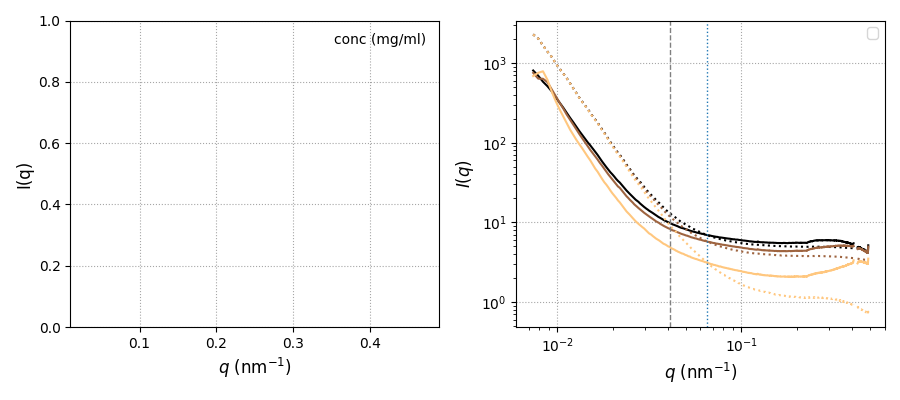

In [16]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

q_index = 70
fromq = 75
n = 120

for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    scale = Iq_apo[n]/t_exp_apo - Iqs[i,n]/t_exp[i]
    iq_bg = Iq_apo/t_exp_apo - scale
    # y = Iqs[i,fromq:]/t_exp[i] - iq_bg[fromq:]

    # -- right plot
    # a2.plot(qI, Iqs[i,:], ls='-', c=col[i], label=concs[i])
    
    a2.plot(qI, Iqs[i,:]/t_exp[i], ls='-', c=col[i])
    a2.plot(q_apo, iq_bg, ls=':',  c=col[i])
    # a2.plot(qI, Iqs[i,:]/Iqs[i,q_index], ls='-', c=col[i])

# a2.plot(qI, Iq_bkg/Iq_bkg[q_index], ls='--', c='k')
# a2.plot(q_apo, Iq_apo/Iq_apo[q_index], ls='--', c='r')

# a2.plot(q_apo, Iq_apo/t_exp_apo - scale, ls='--', c='r')

a2.axvline(x=qI[n], ls=':', c='C0', lw=1)
a2.axvline(x=qI[q_index], ls='--', c='gray', lw=1)

# plot settings
a1.legend(title='conc (mg/ml)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
# a1.set_xscale('log')
# a1.set_yscale('log')
a1.set_xlim(.01,qI[-1])
# a1.set_ylim(0.04,.8)
# a1.set_ylim(7e-1,1.5e0)
a2.set_ylabel('$I(q)$', fontsize=12)
a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_xscale('log')
a2.set_yscale('log')
# a2.set_xlim(.07,.5)
# a2.set_ylim(1e0,8)
a2.legend()

**From ESRF ID02**

In [17]:
f = np.load('../03-source/id02/Iqs.npz')
# f.files
Iqs_id02 = f['Iqs']
q_id02 = f['q']
c_id02 = f['concs']
print(np.shape(Iqs_id02), np.shape(q_id02))

(5, 1500) (1500,)


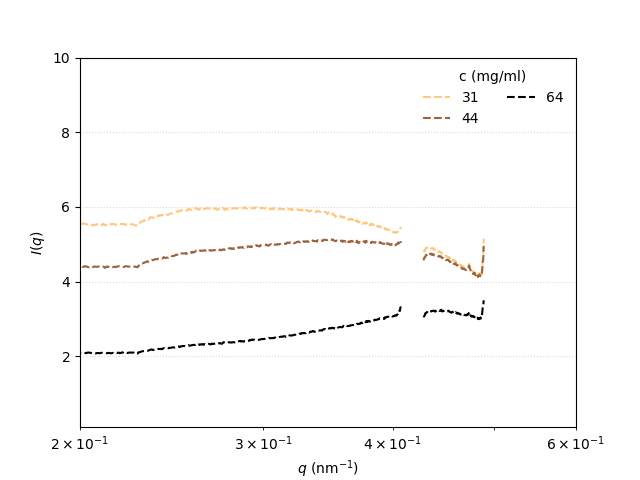

In [18]:
plt.figure()

# # -- id02
# cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)))
# for i in range(1,len(Iqs_id02)-1):
#     plt.plot(q_id02, Iqs_id02[i,:], label=c_id02[i], c=cols[i])

# -- id10
cols2 = plt.cm.copper_r(np.linspace(0,1,len(datasetnumbers)))
q_index = 70
fromq = 75
n = 120

for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    scale = Iq_apo[n]/t_exp_apo - Iqs[i,n]/t_exp[i]
    iq_bg = Iq_apo/t_exp_apo - scale
    y = Iqs[i,fromq:]/t_exp[i] - iq_bg[fromq:]
    
    plt.plot(qI, Iqs[i,:]/t_exp[i], ls='--', c=cols2[i], label=concs[i])
    # plt.plot(q_apo, iq_bg, ls=':',  c=col[i])
  
# a2.axvline(x=qI[n], ls=':', c='C0', lw=1)
# a2.axvline(x=qI[q_index], ls='--', c='gray', lw=1)

# -- plot settings
plt.legend(title='c (mg/ml)', frameon=False, ncol=2)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
plt.xlim(0.2,0.6)
plt.ylim(0.1,10)
plt.grid(ls=':', c='gray', alpha=.3)

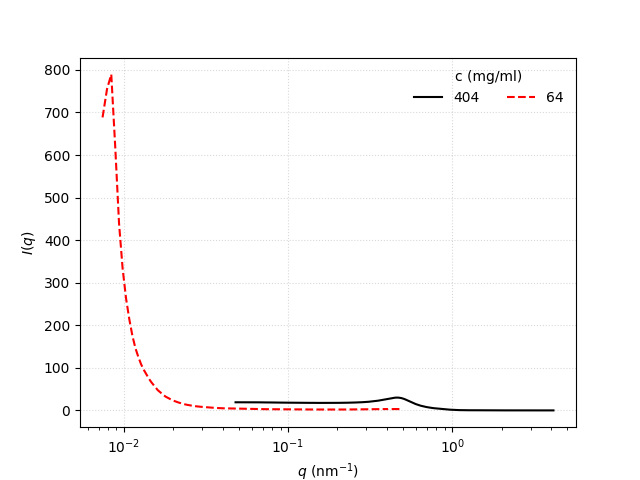

In [19]:
plt.figure()

# -- id02
plt.plot(q_id02, Iqs_id02[0,:], label=c_id02[0], c='k')

# -- id10
cols2 = plt.cm.copper_r(np.linspace(0,1,len(datasetnumbers)))
q_index = 70
fromq = 75
n = 120
scale = Iq_apo[n]/t_exp_apo - Iqs[i,n]/t_exp[i]
iq_bg = Iq_apo/t_exp_apo - scale

i = -1
# y = Iqs[i,fromq:]/t_exp[i] - iq_bg[fromq:]
plt.plot(qI, Iqs[i,:]/t_exp[i], ls='--', c='r', label=concs[i])

# -- plot settings
plt.legend(title='c (mg/ml)', frameon=False, ncol=2)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.ylabel('$I(q)$')
# plt.xlim(0.05,0.6)
# plt.ylim(0.1,50)

plt.grid(ls=':', c='gray', alpha=.3)

In [20]:
import scipy as sp
import scipy.interpolate

0.1616860226563179 0.17614996773433272 0.47989281437264364
0.16521844 0.19251414 0.4709302


(0.0, 1.5)

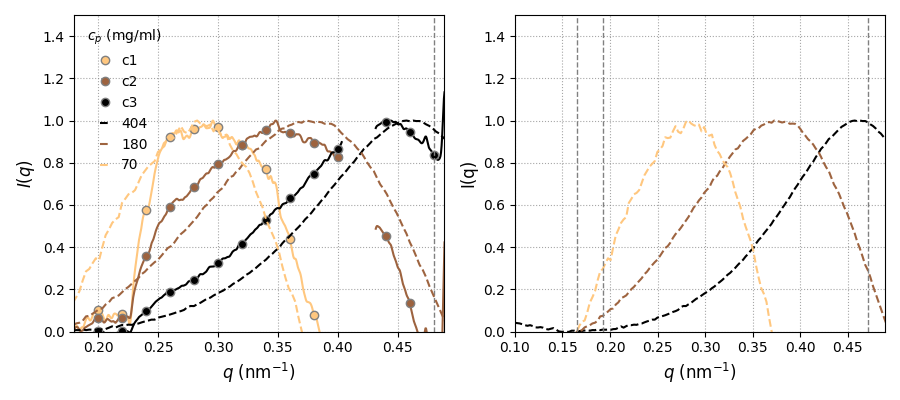

In [21]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
# -- left id10
col = plt.cm.copper_r(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

c_id10 = ['c1', 'c2', 'c3']
for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    if i==0:
        q_new = np.linspace(0.068, 0.37, 20)
        q_new = np.arange(0.2, 0.4, 0.02)
    else:
        q_new = np.linspace(0.2, 0.468, 20)
        q_new = np.arange(0.2, 0.5, 0.02)
    # a1.plot(qI, y, ls='--',  c=col[i]) 
    a1.plot(qI, (y_smooth-b)/A, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))

a1.axvline(x=qI[qi_min], ls='--', c='gray', lw=1)
a1.axvline(x=qI[qi_min+qistep], ls='--', c='gray', lw=1)
a1.axvline(x=qI[qi_max], ls='--', c='gray', lw=1)
print(qI[qi_min], qI[qi_min+qistep], qI[qi_max])

# -- right id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))

for j in range(len(Iqs_id02)-2):
    qi_min, qistep, qi_max = 43, 10, 155
    # b2 = np.mean(Iqs_id02[j,qi_min:qi_min+qistep])
    b2 = Iqs_id02[j,qi_min]
    A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

    a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')
    a2.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')

print(q_id02[qi_min], q_id02[qi_min+qistep], q_id02[qi_max])

a2.axvline(x=q_id02[qi_min], ls='--', c='gray', lw=1)
a2.axvline(x=q_id02[qi_min+qistep], ls='--', c='gray', lw=1)
a2.axvline(x=q_id02[qi_max], ls='--', c='gray', lw=1)

# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$', fontsize=12)
a1.set_xlim(.18,qI[-1])
a1.set_ylim(0, 1.5)

a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_ylabel('I(q)', fontsize=12)
a2.set_xlim(.1,qI[-1])
a2.set_ylim(0,1.5)


In [22]:

def gaussian_off(x, a, mean, sigma, c):
    """ Gaussian """
    return a * np.exp( -((x-mean)/sigma)**2 ) + c

[102.13902032 135.33864839 314.42236786]


Text(0.5, 0, 'peak position $q_{\\mathrm{max}}$ (nm$^{-1}$)')

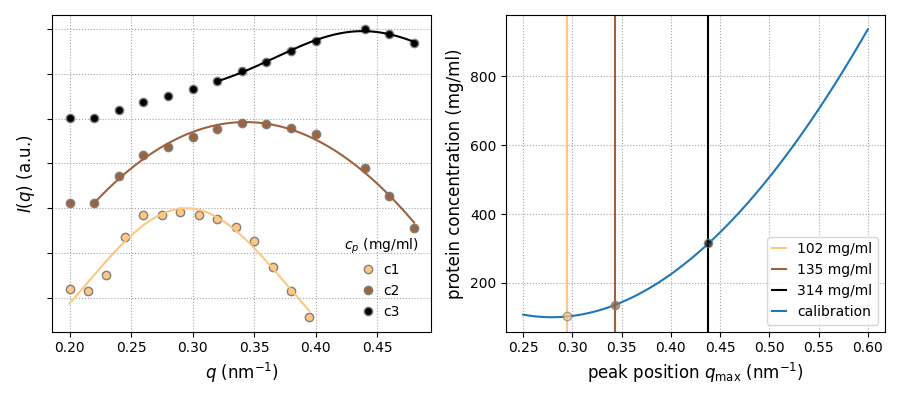

In [23]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
# -- left id10
col = plt.cm.copper_r(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

c_id10 = ['c1', 'c2', 'c3']
q_max = []

for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    
    off = -(i+2.5)
    # off = 0 

    if i==0:
        q_new = np.arange(0.2, 0.4, 0.015)
    else:
        q_new = np.array([0.2,  0.22, 0.24, 0.26, 0.28, 0.3,  0.32, 0.34, 0.36, 0.38, 0.4, 0.44, 0.46, 0.48])    

    # a1.plot(qI, y, ls='--',  c=col[i]) 
    # a1.plot(qI, (y_smooth-b)/A-i+2.5, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    # a1.plot(q_new, y_interp(q_new)-i+2.5, marker='o', mec='gray', c=col[i], ls='',  label=c_id10[i])
    a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',  label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))
    
    # # fit # a, mean, sigma, c
    xmin, xmax = i, -1
    if i == 2:
        xmin = 6
    
    bounds_min = [0, 0, 0.1, -100]
    bounds_max = [1000, 1, 1, 100]

    popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    q_max.append(popt[1])
    a1.plot(xc, curve-off, c=col[i])

# -- anita
conc_i=400
concentrations_preliminary = np.array([730,conc_i,conc_i/2,conc_i/4])
q_max_an=np.array([0.05559127, 0.04679503, 0.0387025 , 0.02814702])*10


qq = np.linspace(0.25, 0.6,100)
z = np.polyfit(q_max_an, concentrations_preliminary, 3)
conc_det = np.poly1d(z)
# -- end of anita

for i in range(len(q_max)):
    a2.axvline(x=q_max[i], ls='-', c=col[i], label=f'{conc_det(q_max[i]):.0f} mg/ml')
    

# plt.plot(q_max_an, concentrations_preliminary, marker='o', ls='', label='XFEL data')
plt.plot(qq, conc_det(qq), c='C0',label='calibration')
print(conc_det(q_max))

for i in range(len(q_max)):
    a2.plot(q_max[i], conc_det(q_max[i]), ls='', marker='o', c=col[i],  mec='gray', alpha=0.7)
# -- plot settings

a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$ (a.u.)', fontsize=12)
a1.set_yticklabels([])
# a1.set_xlim(.18,qI[-1])
# a1.set_ylim(0, 4)
a2.legend(handlelength=1,)# title='$c_p$ (mg/ml)')
a2.set_ylabel(r'protein concentration (mg/ml)', fontsize=12)
a2.set_xlabel(r'peak position $q_{\mathrm{max}}$ (nm$^{-1}$)', fontsize=12)
# plt.savefig('../06-figs/Iq-concentrations.png', dpi=300)

# Save etas from ID10 Sharon

In [24]:
T_gly  = np.array([295, 280, 270, 260, 250, 240, 230, 220, 210, 200, 195, 190, 185, 180])
n_gly = np.array([0.010471, 0.021720, 0.039632, 0.081849, 0.19911, 0.60600, 2.5357, 17.063, 245.70, 13837, 2.6422e+5, 1.6325e7, 1.0385e+10, 4.1674e+15]) # 55 vol% or 23 mol% glycerol 


# estimate, se violation
T_gly_NP = [200, 200, 210, 220, 230, 240, 250, 260, 270] 
n_gly_NP = np.array([85.54957477, 119.02323199, 23.22127666, 4.38809797, 1.07204693, 0.35102528, 0.14339865, 0.06931391, 0.03835427])

In [25]:
np.shape(T_gly_NP), np.shape(n_gly_NP), np.shape(T_gly), np.shape(n_gly)

((9,), (9,), (14,), (14,))

In [26]:
!ls ../03-source/

bkg_apo_conc_gly_50_2_0002.npz
bkg_background_0003.npz
bkg_water_gly_50_2_0002.npz
chi4
contrast_vs_q2.npy
contrast_vs_q.npy
D_ave.npz
D_c1_240611.npz
diffusion_coefficient
dls_c1_19mol.npz
DLS_diff_coeff.npz
dls_dil_55v.npz
dls_diluted.npz
dls_NP_23mol.npz
dls_su13_3.npz
dls_su13.npz
elog
ferritin_conc_gly_50_4_0002_0002_scan0001_g2.npy
ferritin_conc_gly_50_4_0002_scan0001_avg_g2.npy
id02
Iqs_apo_conc_gly_50_2_0006.npz
nice_Iq_c1.npz
ttc-for-paper.npy
viscosity_fit_19mol.npz
viscosity_fit_23mol.npz
viscosity_fit.npz
viscosity_NP.npz
water_gly_50_0002_scan0001_avg.npy
water_gly_50_0002_scan0001.npy
xfel.npz


In [27]:
# np.savez('../03-source/viscosity_NP', T_np=T_gly_NP, eta_np=n_gly_NP, T_gly=T_gly, eta_gly=n_gly)

# Old stuff

In [28]:
ff = np.load('../03-source/nice_Iq_c1.npz')
Iq_nice = ff['Iq']
q_nice = ff['q']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


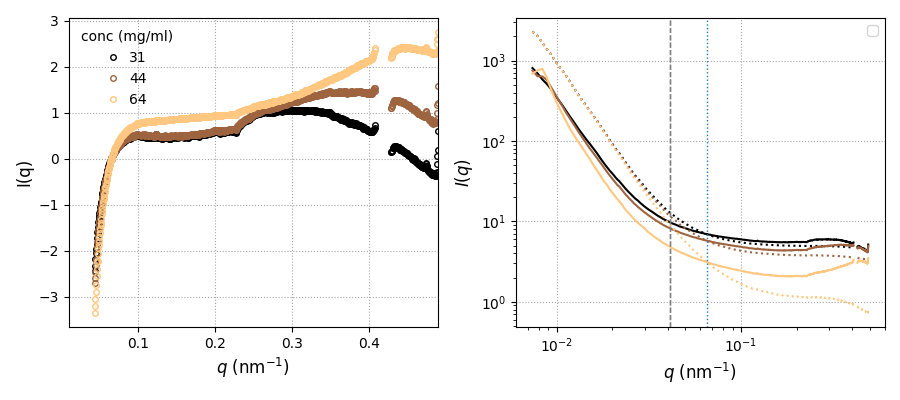

In [29]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

q_index = 70
fromq = 75
n = 120
for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    
    scale = Iq_apo[n]/t_exp_apo - Iqs[i,n]/t_exp[i]
    iq_bg = Iq_apo/t_exp_apo - scale
    y = Iqs[i,fromq:]/t_exp[i] - iq_bg[fromq:]

    # y = Iqs[i,fromq:]/Iqs[i,q_index] - Iq_bkg[fromq:]/Iq_bkg[q_index]
    # y = Iqs[i,fromq:]/Iqs[i,q_index] - Iq_apo[fromq:]/Iq_apo[q_index]
    # y_smooth = gaussian_filter(y, sigma=2)


    # -- left plot
    a1.plot(qI[fromq:], y, ls='', marker='o', ms=4, mfc='none', c=col[i], label=concs[i]) # subtract the lowest conc
    # a1.plot(qI, y_smooth, ls='-', c='r') # subtract the lowest conc

    # a1.plot(qI, Iqs[i,:]/Iqs[i,q_index] - Iq_apo[:]/Iq_apo[q_index], ls='-', c=col[i], label=concs[i]) # subtract apof
    # a2.plot(qI, Iqs[i,:]/Iqs[i,q_index] , ls='-', c=col[i], label=concs[i])
    
    # -- right plot
    # a2.plot(qI, Iqs[i,:], ls='-', c=col[i], label=concs[i])
    

    a2.plot(qI, Iqs[i,:]/t_exp[i], ls='-', c=col[i])
    a2.plot(q_apo, iq_bg, ls=':',  c=col[i])
    # a2.plot(qI, Iqs[i,:]/Iqs[i,q_index], ls='-', c=col[i])

    # y = Iqs[i,:]-Iq_bkg/t_exp_bkg*t_exp[i]# - Iq_bkg/Iq_bkg[6]*Iqs[i,6]
    # y = Iqs[i,:] - Iq_bkg/Iq_bkg[q_index]*Iqs[i,q_index]
    # a2.plot(qI, y, c=col[i], ls='-', label=concs[i])

# a2.plot(qI, Iq_bkg/Iq_bkg[q_index], ls='--', c='k')
# a2.plot(q_apo, Iq_apo/Iq_apo[q_index], ls='--', c='r')
a2.axvline(x=qI[n], ls=':', c='C0', lw=1)
# a2.plot(q_apo, Iq_apo/t_exp_apo - scale, ls='--', c='r')

a2.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
a2.axvline(x=qI[q_index], ls='--', c='gray', lw=1)

# plot settings
a1.legend(title='conc (mg/ml)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
# a1.set_xscale('log')
# a1.set_yscale('log')
a1.set_xlim(.01,qI[-1])
# a1.set_ylim(0.04,.8)
# a1.set_ylim(7e-1,1.5e0)
a2.set_ylabel('$I(q)$', fontsize=12)
a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_xscale('log')
a2.set_yscale('log')
# a2.set_xlim(.07,.5)
# a2.set_ylim(1e0,8)
a2.legend()

In [30]:
# -- backgrounds
# f, (a1) = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
# col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

# q_index = 450

# # a1.plot(q_apo, Iq_apo, ls='-', label='apof')

# a1.plot(q_apo, Iq_apo/t_exp_apo, ls='-', label='apof')
# a1.plot(q_bkg, Iq_bkg/t_exp_bkg, ls='-', label='empty')
# a1.plot(q_bkg_w, Iq_bkg_w/t_exp_bkg_w, ls='-', label='wat/gl')

# # a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
# a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
# a1.set_ylabel('I(q)', fontsize=12)
# # a1.set_xscale('log')
# # a1.set_yscale('log')
# a1.set_xlim(.1,qI[-1])
# a1.set_ylim(0,1e0)

## log interpolation

In [31]:
import scipy as sp
import scipy.interpolate

In [32]:
q_new = [0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.468]

In [33]:
qI[fromq]

0.043563804519197

(0.02, 0.489053312922053)

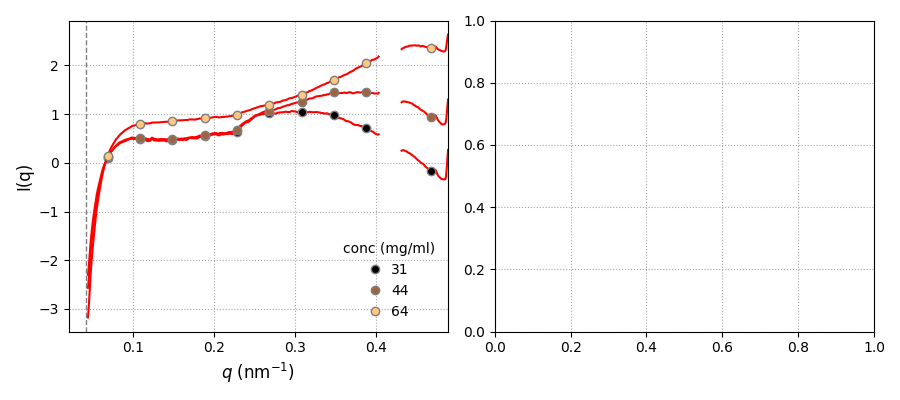

In [34]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

q_new = [0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.468]

# # q_index = 50
# q_index = 70
# fromq = 75

Iq_interp, q_interp = [], []

for i in range(len(datasetnumbers)):
    # new attempt
    scale = Iq_apo[n]/t_exp_apo - Iqs[i,n]/t_exp[i]
    iq_bg = Iq_apo/t_exp_apo - scale
    y = Iqs[i,fromq:]/t_exp[i] - iq_bg[fromq:]

    # old
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    # y = Iqs[i,:]/Iqs[i,q_index] - Iq_bkg/Iq_bkg[q_index]
    y_smooth = gaussian_filter(y, sigma=2)
    
    # a1.plot(qI, y, ls='', marker='o', ms=4, mfc='none', c=col[i], label=concs[i]) # subtract the lowest conc
    a1.plot(qI[fromq:], y_smooth, ls='-', c='r') # subtract the lowest conc

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI[fromq:], y_smooth, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=concs[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))

# a1.plot(qI, Iq_bkg/Iq_bkg[q_index], ls='--', c='k')
a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)

# for q in qv:
#     a1.axvline(x=q, c='gray', ls='--')

a1.legend(title='conc (mg/ml)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
a1.set_xlim(.02,qI[-1])
# a1.set_ylim(0.1,.8)


## S(q) with XFEL

In [35]:
q_interp[0]

[0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.468]

In [36]:
q_interp[2]

[0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.468]

(0.02, 0.8)

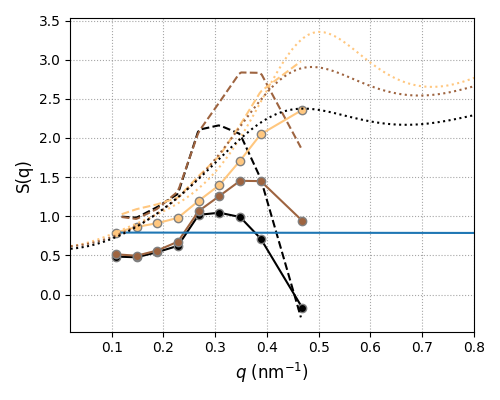

In [37]:
f, a1 = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

until = 88
# a1.axvline(x=xfel['q_form_factor'][until])
qq_new = xfel['q_form_factor'][:until]


for i,(iq,q) in enumerate(zip(Iq_interp,q_interp)):
    Iq = iq[1:]#/iq[2]
    Q = q[1:]
    func =  sp.interpolate.interp1d(Q, Iq, kind='linear')
    
    a1.plot(qq_new, func(qq_new), c=col[i], ls='-')
    a1.plot(Q, Iq, marker='o', mec='gray', c=col[i], ls='',  label=f'Iq {concs[i]}')
    
    ff = xfel['form_factor'] + abs(xfel['form_factor'][0]-Iq[0])

    a1.plot(qq_new, func(qq_new) / ff[:until], c=col[i], ls='--')

a1.plot(xfel['q_form_factor'], ff ,label='form factor')

for i in range(3):
    a1.plot(xfel['q_theory'], xfel['S_theory'][:,i]/xfel['S_theory'][17,i], ls=':', c=col[::-1][i], label=i)
# a1.axvline(x=xfel['q_theory'][17])

# a1.legend(title='conc (mg/ml)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('S(q)', fontsize=12)
a1.set_xlim(.02,.8)
# a1.set_ylim(0.1,.8)


# XFEL ferritin

In [38]:
f = np.load("../03-source/xfel.npz")
xfel = {}
for key in f.files:
    xfel[key] = f[key]
    print(key, np.shape(xfel[key]))

q_form_factor (256,)
form_factor (256,)
H_theory (2999, 3)
S_theory (2999, 3)
q_theory (2999,)
qvalues (15,)
dH_Q (3, 15)
H_Q (3, 15)
D (3, 15)
dD (3, 15)


Text(0, 0.5, 'D(q)')

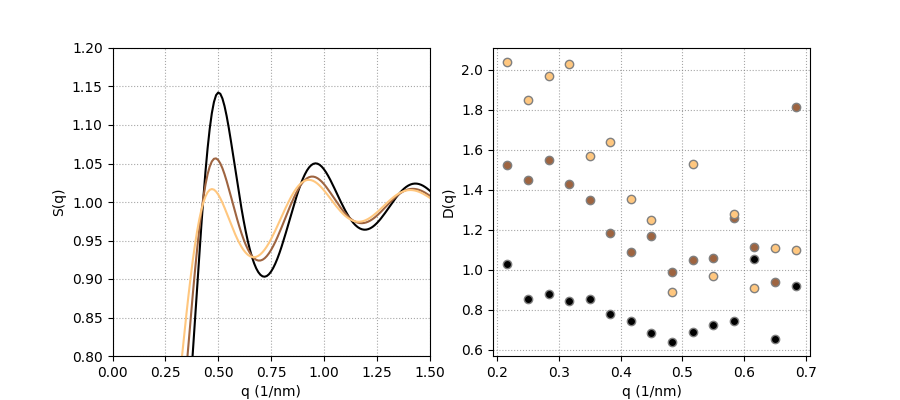

In [39]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(9,4))
cols = plt.cm.copper(np.linspace(0,1,3))
# -- I(q) S(q)
# a1.plot(xfel['q_form_factor'], xfel['form_factor'])

for i in range(3):
    a1.plot(xfel['q_theory'], xfel['S_theory'][:,i], c=cols[i], label=i)

a1.set_xlabel('q (1/nm)')
a1.set_ylabel('S(q)')
a1.set_ylim(0.8,1.2)
a1.set_xlim(0,1.5)

# -- D(q), H(q)
for i in range(3):
    a2.plot(xfel['qvalues'], xfel['D'][i,:], c=cols[i], marker='o', mec='gray', ls='', label=i)

a2.set_xlabel('q (1/nm)')
a2.set_ylabel('D(q)')
# a2.set_ylim(0.8,1.2)
# a1.set_xlim(0,1.5)
